# Código testando as estratégias de divisão dos dados sem fine-tuning

100 épocas.
Usando Shuffle = False em tudo e sem semente

Neste código serão criados 3 modelos usando 3 estratégias diferentes. Os modelos serão treinados, validados e testados usando  o dataset Supermarket Produce (ROCHA et al., 2010).

As estratégias serão as seguintes:
- 1ª estratégia (2_est): 50% do dataset para treino e 50% para teste;
- 2ª estratégia (3_est): 70% do dataset para treino e 30% para teste;
- 3ª estratégia (4_est): 80% do dataset para treino e 20% para teste.

In [1]:
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)

from tensorflow import keras
print("versão do Keras:", keras.__version__)

# IMPORTANDO COMANDOS E FUNÇÕES #

import numpy             as np
import h5py
import matplotlib.pyplot as plt #gerar gráfico
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks           import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score

import pickle

# IMPORTANDO LAYERS PARA A CNN #

from keras.models import Sequential
from keras        import layers
from keras.layers import Dropout

Versão do TensorFlow: 2.5.0
versão do Keras: 2.5.0


In [2]:
print("versao do h5py:", h5py.__version__)

versao do h5py: 3.1.0


In [3]:
# MONTANDO A ESTRUTURA DA CNN #

modelo = Sequential()
modelo.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(Dropout(0.5)) # dropout de 50%
modelo.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(Dropout(0.5))
modelo.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(Dropout(0.5))

modelo.add(layers.Flatten()) # camada de achatamento
modelo.add(layers.Dense(64, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(layers.Dense(units = 11, activation = 'softmax')) # 11 unidades de saída (11 classes)

In [4]:
modelo.summary() # resumo da estrutura, com os parâmetros ajustáveis

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

In [5]:
modelo.save('model_base.h5',
          overwrite = True) 

In [6]:
# Importando a função (criada pelo Gustavo) que faz a separação dos dados em treino e teste

from functions_extras_v2 import criar_treino_teste

Criando particionamento
	 492 	+ 164 	= 656 	 -> apple1
	 492 	+ 164 	= 656 	 -> granny_smith_apple
	 466 	+ 156 	= 622 	 -> kiwi
	 492 	+ 164 	= 656 	 -> lime
	 492 	+ 164 	= 656 	 -> nectarine
	 438 	+ 146 	= 584 	 -> onion
	 492 	+ 164 	= 656 	 -> peach
	 492 	+ 164 	= 656 	 -> pear
	 421 	+ 141 	= 562 	 -> plum
	 450 	+ 150 	= 600 	 -> potato
	 474 	+ 158 	= 632 	 -> watermelon
Particionamento criado com sucesso!


## Primeira estratégia: 50% treino 50% teste

In [7]:
# Puxando a estrutura base da rede

model_n1 = keras.models.load_model('model_base.h5')

In [8]:
model_n1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [9]:
criar_treino_teste('./dataset_smkt/', 0.5)

Criando particionamento
	 106 	+ 106 	= 212 	 -> apple1
	 77 	+ 78 	= 155 	 -> granny_smith_apple
	 85 	+ 86 	= 171 	 -> kiwi
	 53 	+ 53 	= 106 	 -> lime
	 123 	+ 124 	= 247 	 -> nectarine
	 37 	+ 38 	= 75 	 -> onion
	 105 	+ 106 	= 211 	 -> peach
	 79 	+ 80 	= 159 	 -> pear
	 132 	+ 132 	= 264 	 -> plum
	 100 	+ 101 	= 201 	 -> potato
	 96 	+ 96 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [10]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.25) # comando para reescala + divisão em 20% para validação

# imagens de treino (75%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         shuffle = False,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (25%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset = 'validation',
                                         batch_size = 64,
                                         shuffle = False,
                                         target_size = (100, 100))

Found 748 images belonging to 11 classes.
Found 245 images belonging to 11 classes.


In [11]:
# INÍCIO DO TREINO DO MODELO #

history = model_n1.fit(train_data,
                    epochs=100,
                    validation_data=valid_data,
                    verbose=True)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
12/12 [==============================] - 15s 1s/step - loss: 3.5047 - accuracy: 0.0468 - val_loss: 2.3975 - val_accuracy: 0.0694
Epoch 2/100
12/12 [==============================] - 15s 1s/step - loss: 2.3987 - accuracy: 0.1110 - val_loss: 2.3969 - val_accuracy: 0.1347
Epoch 3/100
12/12 [==============================] - 16s 1s/step - loss: 2.3968 - accuracy: 0.0963 - val_loss: 2.3966 - val_accuracy: 0.1347
Epoch 4/100
12/12 [==============================] - 16s 1s/step - loss: 2.3968 - accuracy: 0.1190 - val_loss: 2.3960 - val_accuracy: 0.1347
Epoch 5/100
12/12 [==============================] - 15s 1s/step - loss: 2.3959 - accuracy: 0.1083 - val_loss: 2.3954 - val_accuracy: 0.1347
Epoch 6/100
12/12 [==============================] - 17s 1s/step - loss: 2.3948 - accuracy: 0.1297 - val_loss: 2.3950 - val_accuracy: 0.1347
Epoch 7/100
12/12 [==============================] - 18s 1s/step - loss: 2.3939 - accuracy: 0.1029 - val_loss: 2.3944 - val_accuracy: 0.1347
Epoch 8/100
1

Epoch 59/100
12/12 [==============================] - 15s 1s/step - loss: 2.3492 - accuracy: 0.1444 - val_loss: 2.3246 - val_accuracy: 0.1592
Epoch 60/100
12/12 [==============================] - 16s 1s/step - loss: 2.4148 - accuracy: 0.1591 - val_loss: 2.3186 - val_accuracy: 0.1714
Epoch 61/100
12/12 [==============================] - 16s 1s/step - loss: 2.3739 - accuracy: 0.0896 - val_loss: 2.3666 - val_accuracy: 0.1347
Epoch 62/100
12/12 [==============================] - 15s 1s/step - loss: 2.3565 - accuracy: 0.1618 - val_loss: 2.3563 - val_accuracy: 0.1837
Epoch 63/100
12/12 [==============================] - 15s 1s/step - loss: 2.3171 - accuracy: 0.2433 - val_loss: 2.3158 - val_accuracy: 0.2612
Epoch 64/100
12/12 [==============================] - 16s 1s/step - loss: 2.2699 - accuracy: 0.2326 - val_loss: 2.2050 - val_accuracy: 0.2776
Epoch 65/100
12/12 [==============================] - 16s 1s/step - loss: 2.3149 - accuracy: 0.1618 - val_loss: 2.2342 - val_accuracy: 0.2408
Epoch 

In [12]:
model_n1.save('model_n1.h5',
          overwrite = True) 
del model_n1

with open('trainHistoryDict_model_n1', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [13]:
model_n1 = keras.models.load_model('model_n1.h5')
history = pickle.load(open('trainHistoryDict_model_n1', "rb"))

In [14]:
model_n1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

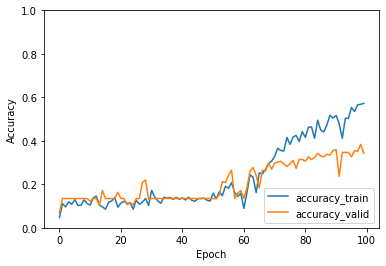

In [15]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

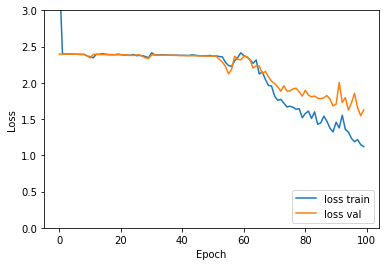

In [16]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [17]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 1000 images belonging to 11 classes.


In [18]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_n1.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

16/16 [==============================] - 11s 670ms/step - loss: 1.1578 - accuracy: 0.5450
acurácia nos dados de teste: 0.5450000166893005
loss dos dados de teste: 1.157800555229187


In [19]:
Y_pred = model_n1.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(1000,)
Accuracy
0.545
Balanced Accuracy
0.5478145323745754
Confusion Matrix
[[ 50   0   1   0  16   0  17  10  12   0   0]
 [  0   4   6   0  11   0   0  18  23   9   7]
 [  1   1  10   0  19   0   0   8  40   7   0]
 [  0   0   0  51   0   2   0   0   0   0   0]
 [  2   1   0   0  54   0   2  43  22   0   0]
 [  0   0   0   0   0  23   0   0   0  15   0]
 [ 32   0   3   0  25   0  37   4   5   0   0]
 [  0   0   0   0   5   0   1  69   3   0   2]
 [  0   0   0   0   0   0   0   0 132   0   0]
 [  0  10   0   0   0  25   0   4   1  50  11]
 [  0   0   0   0   0  12   0   8   0  11  65]]
Classification Report


## Segunda estratégia: 70% treino e 30% teste

In [20]:
# Puxando estrutura do modelo base

model_n2 = keras.models.load_model('model_base.h5')

In [21]:
model_n2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [22]:
criar_treino_teste('./dataset_smkt/', 0.3)

Criando particionamento
	 148 	+ 64 	= 212 	 -> apple1
	 108 	+ 47 	= 155 	 -> granny_smith_apple
	 119 	+ 52 	= 171 	 -> kiwi
	 74 	+ 32 	= 106 	 -> lime
	 172 	+ 75 	= 247 	 -> nectarine
	 52 	+ 23 	= 75 	 -> onion
	 147 	+ 64 	= 211 	 -> peach
	 111 	+ 48 	= 159 	 -> pear
	 184 	+ 80 	= 264 	 -> plum
	 140 	+ 61 	= 201 	 -> potato
	 134 	+ 58 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [23]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.25) # comando para reescala + divisão em 20% para validação

# imagens de treino (75%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         shuffle = False,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (25%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset='validation',
                                         batch_size = 64,
                                         shuffle = False,
                                         target_size = (100, 100))

Found 1045 images belonging to 11 classes.
Found 344 images belonging to 11 classes.


In [24]:
# INÍCIO DO TREINO DO MODELO #

history = model_n2.fit(train_data,
                    epochs=100,
                    validation_data=valid_data)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
17/17 [==============================] - 25s 1s/step - loss: 3.0081 - accuracy: 0.0794 - val_loss: 2.3974 - val_accuracy: 0.1047
Epoch 2/100
17/17 [==============================] - 21s 1s/step - loss: 2.3942 - accuracy: 0.1100 - val_loss: 2.3968 - val_accuracy: 0.1250
Epoch 3/100
17/17 [==============================] - 22s 1s/step - loss: 2.3917 - accuracy: 0.1139 - val_loss: 2.3958 - val_accuracy: 0.1744
Epoch 4/100
17/17 [==============================] - 22s 1s/step - loss: 2.3936 - accuracy: 0.1062 - val_loss: 2.3936 - val_accuracy: 0.1250
Epoch 5/100
17/17 [==============================] - 21s 1s/step - loss: 2.3908 - accuracy: 0.1014 - val_loss: 2.3916 - val_accuracy: 0.1047
Epoch 6/100
17/17 [==============================] - 22s 1s/step - loss: 2.3967 - accuracy: 0.1206 - val_loss: 2.3885 - val_accuracy: 0.1250
Epoch 7/100
17/17 [==============================] - 22s 1s/step - loss: 2.3779 - accuracy: 0.1301 - val_loss: 2.3903 - val_accuracy: 0.1250
Epoch 8/100
1

Epoch 59/100
17/17 [==============================] - 22s 1s/step - loss: 1.1514 - accuracy: 0.5512 - val_loss: 1.3701 - val_accuracy: 0.4942
Epoch 60/100
17/17 [==============================] - 21s 1s/step - loss: 1.1198 - accuracy: 0.5579 - val_loss: 1.5724 - val_accuracy: 0.4622
Epoch 61/100
17/17 [==============================] - 22s 1s/step - loss: 1.3016 - accuracy: 0.4947 - val_loss: 1.4908 - val_accuracy: 0.4651
Epoch 62/100
17/17 [==============================] - 22s 1s/step - loss: 1.2485 - accuracy: 0.5177 - val_loss: 1.4446 - val_accuracy: 0.4564
Epoch 63/100
17/17 [==============================] - 21s 1s/step - loss: 1.1555 - accuracy: 0.5646 - val_loss: 1.4465 - val_accuracy: 0.4622
Epoch 64/100
17/17 [==============================] - 22s 1s/step - loss: 1.0824 - accuracy: 0.5933 - val_loss: 1.4309 - val_accuracy: 0.4767
Epoch 65/100
17/17 [==============================] - 22s 1s/step - loss: 1.0657 - accuracy: 0.5799 - val_loss: 1.4279 - val_accuracy: 0.5029
Epoch 

In [25]:
model_n2.save('model_n2.h5',
          overwrite = True) 
del model_n2

with open('trainHistoryDict_model_n2', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [26]:
model_n2 = keras.models.load_model('model_n2.h5')
history = pickle.load(open('trainHistoryDict_model_n2', "rb"))

In [27]:
model_n2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

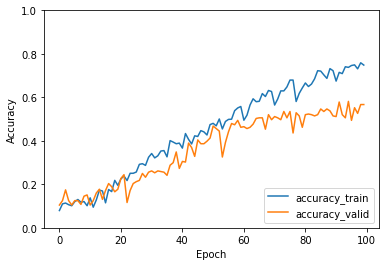

In [28]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

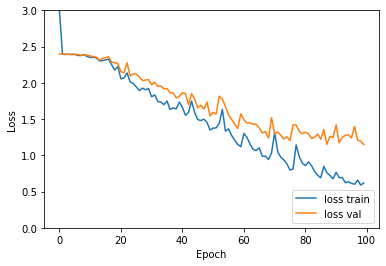

In [29]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [30]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data          = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 604 images belonging to 11 classes.


In [31]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_n2.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

10/10 [==============================] - 7s 665ms/step - loss: 0.5365 - accuracy: 0.8228
acurácia nos dados de teste: 0.8228476643562317
loss dos dados de teste: 0.5365355610847473


In [32]:
Y_pred = model_n2.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(604,)
Accuracy
0.8228476821192053
Balanced Accuracy
0.8129509003260924
Confusion Matrix
[[45  0  4  0  7  0  5  2  1  0  0]
 [ 0 42  0  0  0  0  0  0  0  0  5]
 [ 0  0 35  0 10  0  1  6  0  0  0]
 [ 0  0  0 32  0  0  0  0  0  0  0]
 [ 4  0  9  0 60  0  1  0  0  1  0]
 [ 0  0  0  0  0 13  0  0  0 10  0]
 [10  0  4  0  0  0 49  1  0  0  0]
 [ 1  0  2  0  3  0  1 40  0  0  1]
 [ 0  0  1  0  1  0  0  0 78  0  0]
 [ 0  0  0  0  0  1  0  9  0 50  1]
 [ 0  4  0  0  0  0  0  0  0  1 53]]
Classification Report


## Terceira estratégia: 80% treino e 20% teste

In [33]:
# Criando modelo

model_n3 = keras.models.load_model('model_base.h5')

In [34]:
model_n3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                  from_logits=False,
                  label_smoothing=0,                            #configurações da função loss
                  reduction="auto",
                  name="categorical_crossentropy"),
              metrics=['accuracy'])

In [35]:
criar_treino_teste('./dataset_smkt/', 0.2)

Criando particionamento
	 169 	+ 43 	= 212 	 -> apple1
	 124 	+ 31 	= 155 	 -> granny_smith_apple
	 136 	+ 35 	= 171 	 -> kiwi
	 84 	+ 22 	= 106 	 -> lime
	 197 	+ 50 	= 247 	 -> nectarine
	 60 	+ 15 	= 75 	 -> onion
	 168 	+ 43 	= 211 	 -> peach
	 127 	+ 32 	= 159 	 -> pear
	 211 	+ 53 	= 264 	 -> plum
	 160 	+ 41 	= 201 	 -> potato
	 153 	+ 39 	= 192 	 -> watermelon
Particionamento criado com sucesso!


In [36]:
# DIVIDIR AS IMAGENS EM PARTIÇÃO DE TREINO E VALIDAÇÃO, UTILIZANDO O IMAGEDATAGENERATOR #

datagen =  ImageDataGenerator(rescale = 1./255, validation_split=0.25) # comando para reescala + divisão em 20% para validação

# imagens de treino (75%) 

train_data = datagen.flow_from_directory('dataset_smkt/train', 
                                         subset = 'training',
                                         batch_size = 64,
                                         shuffle = False,
                                         target_size = (100, 100)) # definindo tamanho das imagens

# imagens de validação (25%)

valid_data = datagen.flow_from_directory('dataset_smkt/train',
                                         subset='validation',
                                         batch_size = 64,
                                         shuffle = False,
                                         target_size = (100, 100))

Found 1194 images belonging to 11 classes.
Found 395 images belonging to 11 classes.


In [37]:
# INÍCIO DO TREINO DO MODELO #

history = model_n3.fit(train_data,
                    epochs=100,
                    validation_data=valid_data)

# informação: steps_per_epoch = número de imagens / batch_size

Epoch 1/100
19/19 [==============================] - 28s 1s/step - loss: 3.0444 - accuracy: 0.0578 - val_loss: 2.3971 - val_accuracy: 0.1241
Epoch 2/100
19/19 [==============================] - 26s 1s/step - loss: 2.3967 - accuracy: 0.0871 - val_loss: 2.3965 - val_accuracy: 0.1316
Epoch 3/100
19/19 [==============================] - 24s 1s/step - loss: 2.3953 - accuracy: 0.1030 - val_loss: 2.3956 - val_accuracy: 0.1316
Epoch 4/100
19/19 [==============================] - 26s 1s/step - loss: 2.3982 - accuracy: 0.0804 - val_loss: 2.3948 - val_accuracy: 0.1316
Epoch 5/100
19/19 [==============================] - 25s 1s/step - loss: 2.3932 - accuracy: 0.1281 - val_loss: 2.3939 - val_accuracy: 0.1316
Epoch 6/100
19/19 [==============================] - 25s 1s/step - loss: 2.3939 - accuracy: 0.0771 - val_loss: 2.3889 - val_accuracy: 0.1316
Epoch 7/100
19/19 [==============================] - 25s 1s/step - loss: 2.3791 - accuracy: 0.0963 - val_loss: 2.3710 - val_accuracy: 0.1443
Epoch 8/100
1

Epoch 59/100
19/19 [==============================] - 25s 1s/step - loss: 1.0892 - accuracy: 0.5812 - val_loss: 1.3188 - val_accuracy: 0.4861
Epoch 60/100
19/19 [==============================] - 25s 1s/step - loss: 1.4807 - accuracy: 0.4832 - val_loss: 1.4893 - val_accuracy: 0.4456
Epoch 61/100
19/19 [==============================] - 24s 1s/step - loss: 1.4406 - accuracy: 0.4623 - val_loss: 1.6494 - val_accuracy: 0.3620
Epoch 62/100
19/19 [==============================] - 25s 1s/step - loss: 1.3486 - accuracy: 0.4816 - val_loss: 1.5089 - val_accuracy: 0.4481
Epoch 63/100
19/19 [==============================] - 24s 1s/step - loss: 1.1396 - accuracy: 0.5821 - val_loss: 1.3694 - val_accuracy: 0.4785
Epoch 64/100
19/19 [==============================] - 25s 1s/step - loss: 1.0457 - accuracy: 0.5812 - val_loss: 1.2244 - val_accuracy: 0.5291
Epoch 65/100
19/19 [==============================] - 25s 1s/step - loss: 0.9307 - accuracy: 0.6374 - val_loss: 1.2488 - val_accuracy: 0.5063
Epoch 

In [38]:
model_n3.save('model_n3.h5',
          overwrite = True) 
del model_n3

with open('trainHistoryDict_model_n3', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [39]:
model_n3 = keras.models.load_model('model_n3.h5')
history = pickle.load(open('trainHistoryDict_model_n3', "rb"))

In [40]:
model_n3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        3

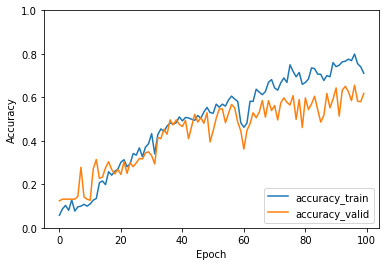

In [41]:
# GERANDO GRÁFICO COM RESULTADOS DAS ACURÁCIAS DE TREINO E VALIDAÇÃO #

plt.plot(history['accuracy'], label='accuracy_train')
plt.plot(history['val_accuracy'], label = 'accuracy_valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

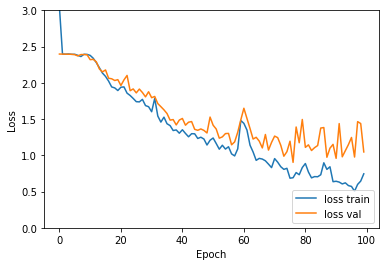

In [42]:
# GERANDO GRÁFICO COM RESULTADOS DO LOSS DE TREINO E VALIDAÇÃO #

plt.plot(history['loss'], label='loss train')
plt.plot(history['val_loss'], label='loss val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')

In [43]:
datagen_test =  ImageDataGenerator(rescale = 1./255) # comando para reescala das imagens de teste

# imagens de teste

test_data = datagen_test.flow_from_directory(directory='dataset_smkt/test',
                                                      target_size = (100, 100),
                                                      batch_size = 64,
                                                      shuffle=False)

Found 404 images belonging to 11 classes.


In [44]:
# DEFININDO COMANDO PARA AVALIAR O DESEMPENHO DO MODELO NAS IMAGENS DE TESTE #

test_loss, test_acc = model_n3.evaluate(test_data) # verificar versão do Keras

print("acurácia nos dados de teste:", test_acc)
print("loss dos dados de teste:", test_loss)

7/7 [==============================] - 5s 646ms/step - loss: 0.4917 - accuracy: 0.8416
acurácia nos dados de teste: 0.8415841460227966
loss dos dados de teste: 0.49171677231788635


In [45]:
Y_pred = model_n3.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(y_pred.shape)

print('Accuracy')
print(accuracy_score(test_data.classes,y_pred))

print('Balanced Accuracy')
print(balanced_accuracy_score(test_data.classes,y_pred))

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')

(404,)
Accuracy
0.8415841584158416
Balanced Accuracy
0.8364997064521582
Confusion Matrix
[[35  0  1  0  2  0  4  0  1  0  0]
 [ 0 27  0  0  0  0  0  0  0  0  4]
 [ 0  0 23  0  2  0  1  0  9  0  0]
 [ 0  0  0 21  0  0  1  0  0  0  0]
 [ 3  0  3  0 43  0  0  0  1  0  0]
 [ 0  0  0  0  0 11  0  0  0  4  0]
 [ 4  0  1  0  1  0 36  0  1  0  0]
 [ 0  0  2  0  0  0  2 27  1  0  0]
 [ 2  0  0  0  1  0  0  1 49  0  0]
 [ 0  0  7  0  0  4  0  0  0 30  0]
 [ 0  1  0  0  0  0  0  0  0  0 38]]
Classification Report


#### Referência:

ROCHA, A. et al. Automatic fruit and vegetable classification from images. Computers and Electronics in Agriculture, v. 70, n. 1, p. 96-104, 2010.